In [1]:
import os
import csv
import sys
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

In [2]:
ls ../results

epoch-results_0-AR_222_24_25_1e-06_256_32.csv
epoch-results_0-BW_222_24_25_1e-06_128_128.csv
epoch-results_0_222_24_1_1e-06_16_1024.csv
epoch-results_0_222_24_25_1e-06_128_128.csv
epoch-results_0_222_24_3_1e-06_16_1024.csv
final-bydrug-output-part1_app0_ref0_222_24_25_1e-06.csv.gz
final-bydrug-output-part2_app0_ref0_222_24_25_1e-06.csv.gz
final-bydrug-output-part3_app0_ref0_222_24_25_1e-06.csv.gz
final-bydrug-output-part4_app0_ref0_222_24_25_1e-06.csv.gz
final-bydrug-test_0_222_24_25_1e-06.csv
final-bydrug-test_0_222_24_25_1e-06_256_32.csv
final-bydrug-test_1_222_24_25_1e-06.csv
final-bydrug-test_2_222_24_25_1e-06.csv
final-bydrug-test_3_222_24_25_1e-06.csv
final-bydrug-test_4_222_24_25_1e-06.csv
final-bydrug-train_0_222_24_25_1e-06.csv
final-bydrug-train_1_222_24_25_1e-06.csv
final-bydrug-valid_0_222_24_25_1e-06.csv
final-bydrug-valid_0_222_24_25_1e-06_256_32.csv
final-bydrug-valid_1_222_24_25_1e-06.csv
final-bydrug-valid_2_222_24_25_1e-06.csv
final-bydrug-valid_3_222_24_25_1e-06.csv


In [8]:
split = 'test'
results_files = [f'../results/final-bydrug-{split}_0_222_24_25_1e-06.csv', 
                 f'../results/final-bydrug-{split}_0_222_24_25_1e-06_256_32.csv',
                ]

In [9]:
labels = {'not_event': 0, 'is_event': 1}
colors = sns.color_palette("hls", len(results_files))

 refset: 0
 np_random_seed: 222
 random_state: 24
 EPOCHS: 25
 LR: 1e-06
 max_length: 128
 batch_size: 128
160 20 20
 valid thresh: 1.73684511333704
 test thresh : 1.7360363006591797

 refset: 0
 np_random_seed: 222
 random_state: 24
 EPOCHS: 25
 LR: 1e-06
 max_length: 256
 batch_size: 32
160 20 20
 valid thresh: 2.7796970307826996
 test thresh : 2.783777594566345



<ipython-input-10-48406c8bba6e>:135: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)
<ipython-input-10-48406c8bba6e>:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)


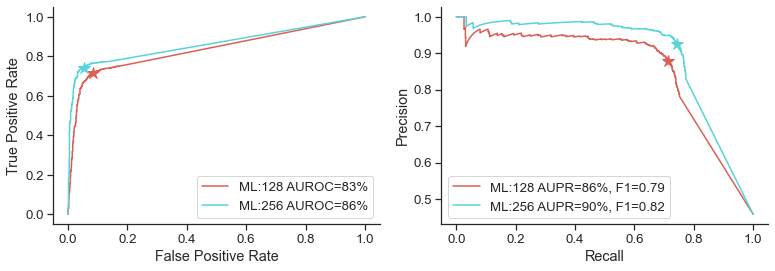

In [10]:
sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(11,4))
first = True

if split == 'valid':
    max_f1_thresholds = dict()

for rpi, resultspath in enumerate(results_files):
    
    fnnoext = os.path.split(resultspath)[-1].split('.')[0]
    
    refset = fnnoext.split('_')[1]
    np_random_seed = int(fnnoext.split('_')[2])
    random_state = int(fnnoext.split('_')[3])
    EPOCHS = int(fnnoext.split('_')[4])
    LR = fnnoext.split('_')[5]
    
    if len(fnnoext.split('_')) == 8:
        max_length = fnnoext.split('_')[6]
        batch_size = fnnoext.split('_')[7]
    else:
        max_length = 128
        batch_size = 128

    print(f" refset: {refset}")
    print(f" np_random_seed: {np_random_seed}")
    print(f" random_state: {random_state}")
    print(f" EPOCHS: {EPOCHS}")
    print(f" LR: {LR}")
    print(f" max_length: {max_length}")
    print(f" batch_size: {batch_size}")
    
    datapath = f'../data/ref{refset}_clinical_bert_reference_set.txt'
    df = pd.read_csv(datapath)
    
    druglist = sorted(set(df['drug']))

    random.seed(np_random_seed)
    random.shuffle(druglist)

    drugs_train, drugs_val, drugs_test = np.split(druglist, [int(0.8*len(druglist)), int(0.9*len(druglist))])

    print(len(drugs_train), len(drugs_val), len(drugs_test))

    df_train = df[df['drug'].isin(drugs_train)]
    df_val = df[df['drug'].isin(drugs_val)]
    df_test = df[df['drug'].isin(drugs_test)]

    #df_train.shape, df_val.shape, df_test.shape
    
    if split == 'test':
        df_touse = df_test
        drugs_touse = drugs_test
    elif split == 'valid':
        df_touse = df_val
        drugs_touse = drugs_val
    elif split == 'train':
        df_touse = df_train
        drugs_touse = drugs_train
    else:
        raise Exception(f"Split has unexpected value: {split}")
    
    refset_fn = '../data/200_manual_annotations_csv/FinalReferenceStandard200Labels.csv'
    refset_fh = open(refset_fn)
    reader = csv.reader(refset_fh, delimiter='|')
    header = next(reader)

    gold_standard = set()
    for row in reader:
        data = dict(zip(header, row))
        if data['Section Display Name'] != 'ADVERSE REACTIONS':
            continue

        if not data['Drug Name'] in drugs_touse:
            continue

        gold_standard.add((data['Drug Name'], data['Matching String'].lower()))
    
    refset_fh.close()
    len(gold_standard)

    
    res = pd.read_csv(resultspath, header=None)
    
    df_touse['Pred0'] = res[0].to_numpy()
    df_touse['Pred1'] = res[1].to_numpy()
    
    df_touse_grouped = df_touse[['drug', 'llt', 'Pred1', 'Pred0']].groupby(by=['drug', 'llt']).mean().reset_index()
    
    
    # for all of the drug, event pairs that couldn't be scored we add them with 0's 
    # otherwise we will way overestimate our recall
    scored_pairs = set()
    for index, row in df_touse_grouped.iterrows():
        scored_pairs.add((row['drug'], row['llt']))

    for d, e in (gold_standard-scored_pairs):
        df_touse_grouped = df_touse_grouped.append({'drug': d, 'llt': e, 'Pred1': 0.0, 'Pred0': 0.0}, ignore_index=True)
    
    grouped_y = [1 if ((row['drug'], row['llt']) in gold_standard) else 0 for index, row in df_touse_grouped.iterrows()]
    
    
    precision, recall, thresholds = metrics.precision_recall_curve(grouped_y, df_touse_grouped['Pred1'])
    numerator = 2 * recall * precision
    denom = recall + precision
    f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
    max_f1 = np.max(f1_scores)
    max_f1_thresh = thresholds[np.argmax(f1_scores)]
    max_f1_precision = precision[np.argmax(f1_scores)]
    max_f1_recall = recall[np.argmax(f1_scores)]
    
    if split == 'valid':
        max_f1_thresholds[resultspath] = (max_f1_thresh, max_f1)
    
    if split == 'test':
        # if this is test, we use the max_f1_threshold from the validation set
        # you must run this entire notebook through for the validation set first
        # otherwise you will an error that the dictionary is not defined
        vthresh = max_f1_thresholds[resultspath.replace('test', 'valid')][0]
        tthresh = thresholds[np.argmin(np.abs(thresholds-vthresh))]
        test_f1_score = f1_scores[np.argmin(np.abs(thresholds-vthresh))]
        test_f1_precision = precision[np.argmin(np.abs(thresholds-vthresh))]
        test_f1_recall = recall[np.argmin(np.abs(thresholds-vthresh))]
        
        # overwrite the max_f1, max_f1_precision, and max_f1_recall so that we don't need a new label/plot line
        max_f1 = test_f1_score
        max_f1_precision = test_f1_precision
        max_f1_recall = test_f1_recall
        
        print(f" valid thresh: {vthresh}")
        print(f" test thresh : {tthresh}")
    
    print("")
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color=colors[rpi], label='ML:%s AUPR=%.0f%%, F1=%.2f' % (max_length, 100*metrics.auc(recall, precision), max_f1))
    plt.plot([max_f1_recall], [max_f1_precision], '*', color=colors[rpi], markersize=12)
    
    plt.legend()
    if first:
        plt.ylabel('Precision')
        plt.xlabel('Recall')
        sns.despine()
    
    plt.subplot(1, 2, 1)
    fpr, tpr, roc_thresholds = metrics.roc_curve(grouped_y, df_touse_grouped['Pred1'])
    max_f1_tpr = tpr[np.argmin(np.abs(roc_thresholds-thresholds[np.argmax(f1_scores)]))]
    max_f1_fpr = fpr[np.argmin(np.abs(roc_thresholds-thresholds[np.argmax(f1_scores)]))]
    
    if split == 'test':
        vthresh = max_f1_thresholds[resultspath.replace('test', 'valid')][0]
        max_f1_tpr = tpr[np.argmin(np.abs(roc_thresholds-vthresh))]
        max_f1_fpr = fpr[np.argmin(np.abs(roc_thresholds-vthresh))]
        
    plt.plot(fpr, tpr, color=colors[rpi], label='ML:%s AUROC=%.0f%%' % (max_length, 100*roc_auc_score(grouped_y, df_touse_grouped['Pred1'])))
    plt.plot([max_f1_fpr], [max_f1_tpr], '*', color=colors[rpi], markersize=12)
    
    plt.legend()
    if first:
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        sns.despine()
    
    first = False

# plt.subplot(1, 2, 2)
# reflegend = 'Reference Sets\n' + '\n'.join([f"{i}: {s}" for i, s in refset_names.items()])
# plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
plt.tight_layout()
plt.savefig(f'../figures/{split}perf_groupedallse-compare-max-length_{np_random_seed}_{random_state}_{EPOCHS}_{LR}.pdf')